In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 100)

from itertools import product
from sklearn.preprocessing import LabelEncoder

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, RandomizedSearchCV, train_test_split

import xgboost as xgb
from xgboost import XGBRegressor
from xgboost import XGBClassifier
from xgboost import plot_importance

from sklearn.metrics import mean_squared_error, mean_absolute_error, average_precision_score, f1_score
from sklearn.metrics import roc_curve, auc, roc_auc_score, accuracy_score, confusion_matrix,classification_report


def plot_features(booster, figsize):    
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax)

from datetime import datetime
import time
import sys
import gc
import pickle
sys.version_info

import joblib
import pickle

## Import Dataset

In [2]:
login = pd.read_csv('../input/iamthebestcoderopen2020/login.csv')
purchase_detail = pd.read_csv('../input/iamthebestcoderopen2020/purchase_detail.csv')
user_info = pd.read_csv('../input/iamthebestcoderopen2020/user_info.csv')
user_label_train = pd.read_csv('../input/iamthebestcoderopen2020/user_label_train.csv')
submission = pd.read_csv('../input/iamthebestcoderopen2020/submission.csv')

## Preprocess personal info

In [3]:
purchase_detail

,userid,grass_date,order_count,total_amount,category_encoded
0,295790,2020-05-13,4,4,8
1,428982,2020-05-13,1,2,14
2,151685,2020-05-13,2,2,12
3,323635,2020-05-13,4,11,8
4,118610,2020-05-13,11,11,17
...,...,...,...,...,...
7792951,275949,2020-03-26,1,1,8
7792952,255131,2020-03-26,1,1,20
7792953,319036,2020-03-26,1,1,15
7792954,511880,2020-03-26,1,1,16


In [4]:
user_info

,userid,gender,is_seller,birth_year,enroll_time
0,1,2.0,1,1985.0,2015-05-27
1,2,1.0,1,1980.0,2015-05-27
2,3,2.0,1,2014.0,2015-05-27
3,4,1.0,1,1978.0,2015-05-27
4,5,1.0,1,1978.0,2015-05-27
...,...,...,...,...,...
502152,521605,2.0,0,2004.0,2020-02-01
502153,521606,2.0,0,1990.0,2020-02-01
502154,521607,1.0,0,NaN,2020-02-01
502155,521608,2.0,0,2005.0,2020-02-01


In [5]:
login

,userid,date,login_times
0,161097,2020-07-29,2
1,243570,2020-07-29,2
2,355497,2020-07-29,4
3,167925,2020-07-29,1
4,504766,2020-07-29,1
...,...,...,...
50705581,203704,2020-02-11,1
50705582,456256,2020-02-11,1
50705583,330731,2020-02-11,1
50705584,481963,2020-02-11,1


In [6]:
user_label_train

,userid,label
0,243381,0
1,150139,1
2,305902,1
3,159981,0
4,490632,0
...,...,...
426827,253227,0
426828,310890,1
426829,208172,0
426830,437306,1


In [7]:
df = pd.merge(user_info, user_label_train, how='left', on='userid')

### Birth date data cleaning

In [8]:
user_info.birth_year.describe()

count    277496.000000
mean       1988.371458
std          10.586304
min        1901.000000
25%        1982.000000
50%        1990.000000
75%        1996.000000
max        2038.000000
Name: birth_year, dtype: float64

In [9]:
## People younger the 5 or order than 70 are not likely to use Shopee
problem = (df['birth_year']> 2015) | (df['birth_year']< 1950)
## Impute with median
df.loc[problem,'birth_year'] = df['birth_year'].median()

In [10]:
pd.to_datetime(df.enroll_time).describe()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  """Entry point for launching an IPython kernel.


count                  502157
unique                   1707
top       2017-11-11 00:00:00
freq                     1505
first     2015-05-27 00:00:00
last      2020-02-01 00:00:00
Name: enroll_time, dtype: object

### Convert enroll date to weeks since register

In [11]:
df['enroll_time'] = pd.to_datetime(df.enroll_time)
dataset_time = '2015-05-27'
df['enroll_weeks'] = (df['enroll_time'] - np.datetime64(dataset_time))/np.timedelta64(1, 'D')/52

In [12]:
df

,userid,gender,is_seller,birth_year,enroll_time,label,enroll_weeks
0,1,2.0,1,1985.0,2015-05-27,0.0,0.000000
1,2,1.0,1,1980.0,2015-05-27,0.0,0.000000
2,3,2.0,1,2014.0,2015-05-27,0.0,0.000000
3,4,1.0,1,1978.0,2015-05-27,0.0,0.000000
4,5,1.0,1,1978.0,2015-05-27,1.0,0.000000
...,...,...,...,...,...,...,...
502152,521605,2.0,0,2004.0,2020-02-01,NaN,32.903846
502153,521606,2.0,0,1990.0,2020-02-01,0.0,32.903846
502154,521607,1.0,0,NaN,2020-02-01,0.0,32.903846
502155,521608,2.0,0,2005.0,2020-02-01,0.0,32.903846


### Data Mark on training and testing

In [13]:
df['data_type'] = np.where((df['label']==1)|(df['label']==0), 1, 2)

# Feature Engineering

## Sales Data Engineering

### Convert datetime data into month

In [14]:
purchase_detail = pd.read_csv('../input/iamthebestcoderopen2020/purchase_detail.csv')

import datetime as dt
purchase_detail['date'] = purchase_detail['grass_date'].apply( lambda x: np.datetime64(x))
purchase_detail['month'] = purchase_detail['date'].dt.month

### Get monthly sales for each user

In [15]:
purchase = purchase_detail.groupby(['userid','month'], as_index=False).agg({'order_count': 'mean','total_amount': 'mean'})
purchase = purchase.pivot(index='userid', columns='month', values='total_amount').reset_index()
purchase.columns = ['userid', 'total_2','total_3','total_4','total_5','total_6','total_7']
purchase = purchase.fillna(0)

In [16]:
df = pd.merge(df,purchase, how='left', on='userid')

In [17]:
##Total amount for each month
d1 = pd.read_csv('../input/iamthebestcoderopen2020/purchase_detail.csv')
d1['date'] = d1['grass_date'].apply( lambda x: np.datetime64(x))
d1['month'] = d1['date'].dt.month
d1 = d1.groupby(['userid','month'], as_index=False).agg({'order_count': 'mean','total_amount': 'sum'})
d1 = d1.pivot(index='userid', columns='month', values='total_amount').reset_index()
d1.columns = ['userid', 'total_2a','total_3a','total_4a','total_5a','total_6a','total_7a']
d1 = d1.fillna(0)

In [18]:
df = pd.merge(df, d1, how='left', on='userid')

In [19]:
##Order count
d2 = pd.read_csv('../input/iamthebestcoderopen2020/purchase_detail.csv')
d2['date'] = d2['grass_date'].apply( lambda x: np.datetime64(x))
d2['month'] = d2['date'].dt.month
d2 = d2.groupby(['userid','month'], as_index=False).agg({'order_count': 'sum','total_amount': 'sum'})
d2 = d2.pivot(index='userid', columns='month', values='order_count').reset_index()
d2.columns = ['userid', 'order_2a','order_3a','order_4a','order_5a','order_6a','order_7a']
d2 = d2.fillna(0)

In [20]:
df = pd.merge(df, d2, how='left', on='userid')

### Get sales of each category for each user

In [21]:
data = pd.read_csv('../input/iamthebestcoderopen2020/purchase_detail.csv')
data = data.groupby(['userid','category_encoded'], as_index=False).size()

In [22]:
data = pd.read_csv('../input/iamthebestcoderopen2020/purchase_detail.csv')
data = data.groupby(['userid','category_encoded'], as_index=False).size()
data = data.pivot(index='userid', columns='category_encoded', values='size').reset_index()
data = data.fillna(0)

In [23]:
df = pd.merge(df, data, how='left', on='userid')

## Login Data Engineering

In [24]:
login = pd.read_csv('../input/iamthebestcoderopen2020/login.csv')

login['date'] = pd.to_datetime(login['date'])
login['login_mm'] = login['date'].dt.month

#初步月整檔
login=login.groupby(['userid','login_mm'], as_index=False).agg({'login_times': 'mean'})

login = login.pivot(index='userid', columns='login_mm', values=['login_times']).reset_index()
login.columns = ['userid', 'avg_login_2','avg_login_3','avg_login_4','avg_login_5','avg_login_6','avg_login_7']

login.head()

,userid,avg_login_2,avg_login_3,avg_login_4,avg_login_5,avg_login_6,avg_login_7
0,1,1.400000,1.166667,1.000000,1.285714,1.500000,1.875000
1,2,2.965517,2.645161,2.366667,2.709677,2.800000,2.580645
2,3,4.482759,4.290323,3.933333,3.935484,4.200000,4.548387
3,4,2.931034,2.193548,2.241379,2.200000,2.535714,2.290323
4,5,5.206897,4.387097,4.533333,4.677419,4.366667,4.032258


In [25]:
df = pd.merge(df, login, how='left', on='userid')

In [26]:
login = pd.read_csv('../input/iamthebestcoderopen2020/login.csv')

login['date'] = pd.to_datetime(login['date'])
login['login_mm'] = login['date'].dt.month


#初步月整檔
login=login.groupby(['userid','login_mm'], as_index=False).agg({'login_times': 'sum'})

login2 = login.pivot(index='userid', columns='login_mm', values=['login_times']).reset_index()
login2.columns = ['userid', 'tot_login_2','tot_login_3','tot_login_4','tot_login_5','tot_login_6','tot_login_7']

login2.head()

,userid,tot_login_2,tot_login_3,tot_login_4,tot_login_5,tot_login_6,tot_login_7
0,1,7.0,7.0,6.0,9.0,6.0,15.0
1,2,86.0,82.0,71.0,84.0,84.0,80.0
2,3,130.0,133.0,118.0,122.0,126.0,141.0
3,4,85.0,68.0,65.0,66.0,71.0,71.0
4,5,151.0,136.0,136.0,145.0,131.0,125.0


In [27]:
df = pd.merge(df, login2, how='left', on='userid')

In [28]:
df.head()

,userid,gender,is_seller,birth_year,enroll_time,label,enroll_weeks,data_type,total_2,total_3,total_4,total_5,total_6,total_7,total_2a,total_3a,total_4a,total_5a,total_6a,total_7a,order_2a,order_3a,order_4a,order_5a,order_6a,order_7a,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,avg_login_2,avg_login_3,avg_login_4,avg_login_5,avg_login_6,avg_login_7,tot_login_2,tot_login_3,tot_login_4,tot_login_5,tot_login_6,tot_login_7
0,1,2.0,1,1985.0,2015-05-27,0.0,0.0,1,85.000000,0.000000,14.500000,2.000000,5.000000,10.000000,170.0,0.0,29.0,2.0,5.0,40.0,5.0,0.0,9.0,1.0,3.0,12.0,0.0,0.0,1.0,0.0,0.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,1.400000,1.166667,1.000000,1.285714,1.500000,1.875000,7.0,7.0,6.0,9.0,6.0,15.0
1,2,1.0,1,1980.0,2015-05-27,0.0,0.0,1,0.000000,2.000000,4.000000,6.333333,3.333333,2.400000,0.0,10.0,8.0,19.0,10.0,12.0,0.0,6.0,3.0,4.0,4.0,8.0,0.0,2.0,0.0,0.0,0.0,2.0,0.0,9.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,2.965517,2.645161,2.366667,2.709677,2.800000,2.580645,86.0,82.0,71.0,84.0,84.0,80.0
2,3,2.0,1,2014.0,2015-05-27,0.0,0.0,1,0.000000,2.000000,2.000000,1.500000,2.333333,0.000000,0.0,2.0,2.0,3.0,7.0,0.0,0.0,2.0,2.0,3.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,4.482759,4.290323,3.933333,3.935484,4.200000,4.548387,130.0,133.0,118.0,122.0,126.0,141.0
3,4,1.0,1,1978.0,2015-05-27,0.0,0.0,1,1.444444,1.000000,2.400000,2.400000,4.166667,3.000000,13.0,5.0,12.0,12.0,25.0,15.0,13.0,5.0,12.0,7.0,8.0,9.0,0.0,0.0,3.0,0.0,0.0,1.0,0.0,9.0,0.0,1.0,2.0,8.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,0.0,0.0,6.0,2.0,2.931034,2.193548,2.241379,2.200000,2.535714,2.290323,85.0,68.0,65.0,66.0,71.0,71.0
4,5,1.0,1,1978.0,2015-05-27,1.0,0.0,1,1.400000,2.454545,199.769231,1.142857,2.222222,4.533333,14.0,27.0,2597.0,8.0,20.0,68.0,11.0,16.0,13.0,8.0,11.0,27.0,2.0,1.0,3.0,6.0,3.0,4.0,0.0,9.0,9.0,8.0,1.0,0.0,2.0,6.0,3.0,3.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,5.206897,4.387097,4.533333,4.677419,4.366667,4.032258,151.0,136.0,136.0,145.0,131.0,125.0


In [29]:
df['rate_login_56']=df['avg_login_6']/df['avg_login_5']+0.00000000001
df['rate_login_67']=df['avg_login_7']/df['avg_login_6']+0.00000000001
df['rate_login_45']=df['avg_login_5']/df['avg_login_4']+0.00000000001
df['rate_login_27']=df['avg_login_7']/df['avg_login_2']+0.00000000001

df.head()

,userid,gender,is_seller,birth_year,enroll_time,label,enroll_weeks,data_type,total_2,total_3,total_4,total_5,total_6,total_7,total_2a,total_3a,total_4a,total_5a,total_6a,total_7a,order_2a,order_3a,order_4a,order_5a,order_6a,order_7a,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,avg_login_2,avg_login_3,avg_login_4,avg_login_5,avg_login_6,avg_login_7,tot_login_2,tot_login_3,tot_login_4,tot_login_5,tot_login_6,tot_login_7,rate_login_56,rate_login_67,rate_login_45,rate_login_27
0,1,2.0,1,1985.0,2015-05-27,0.0,0.0,1,85.000000,0.000000,14.500000,2.000000,5.000000,10.000000,170.0,0.0,29.0,2.0,5.0,40.0,5.0,0.0,9.0,1.0,3.0,12.0,0.0,0.0,1.0,0.0,0.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,1.400000,1.166667,1.000000,1.285714,1.500000,1.875000,7.0,7.0,6.0,9.0,6.0,15.0,1.166667,1.250000,1.285714,1.339286
1,2,1.0,1,1980.0,2015-05-27,0.0,0.0,1,0.000000,2.000000,4.000000,6.333333,3.333333,2.400000,0.0,10.0,8.0,19.0,10.0,12.0,0.0,6.0,3.0,4.0,4.0,8.0,0.0,2.0,0.0,0.0,0.0,2.0,0.0,9.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,2.965517,2.645161,2.366667,2.709677,2.800000,2.580645,86.0,82.0,71.0,84.0,84.0,80.0,1.033333,0.921659,1.144934,0.870218
2,3,2.0,1,2014.0,2015-05-27,0.0,0.0,1,0.000000,2.000000,2.000000,1.500000,2.333333,0.000000,0.0,2.0,2.0,3.0,7.0,0.0,0.0,2.0,2.0,3.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,4.482759,4.290323,3.933333,3.935484,4.200000,4.548387,130.0,133.0,118.0,122.0,126.0,141.0,1.067213,1.082949,1.000547,1.014640
3,4,1.0,1,1978.0,2015-05-27,0.0,0.0,1,1.444444,1.000000,2.400000,2.400000,4.166667,3.000000,13.0,5.0,12.0,12.0,25.0,15.0,13.0,5.0,12.0,7.0,8.0,9.0,0.0,0.0,3.0,0.0,0.0,1.0,0.0,9.0,0.0,1.0,2.0,8.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,0.0,0.0,6.0,2.0,2.931034,2.193548,2.241379,2.200000,2.535714,2.290323,85.0,68.0,65.0,66.0,71.0,71.0,1.152597,0.903226,0.981538,0.781404
4,5,1.0,1,1978.0,2015-05-27,1.0,0.0,1,1.400000,2.454545,199.769231,1.142857,2.222222,4.533333,14.0,27.0,2597.0,8.0,20.0,68.0,11.0,16.0,13.0,8.0,11.0,27.0,2.0,1.0,3.0,6.0,3.0,4.0,0.0,9.0,9.0,8.0,1.0,0.0,2.0,6.0,3.0,3.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,5.206897,4.387097,4.533333,4.677419,4.366667,4.032258,151.0,136.0,136.0,145.0,131.0,125.0,0.933563,0.923418,1.031784,0.774407


In [30]:
#TXN的rate
df['rate_txn_56']=df['total_6']/df['total_5']+0.00000000001
df['rate_total_67']=df['total_7']/df['total_6']+0.00000000001
df['rate_total_45']=df['total_5']/df['total_4']+0.00000000001
df['rate_total_27']=df['total_7']/df['total_2']+0.00000000001

df.head()

,userid,gender,is_seller,birth_year,enroll_time,label,enroll_weeks,data_type,total_2,total_3,total_4,total_5,total_6,total_7,total_2a,total_3a,total_4a,total_5a,total_6a,total_7a,order_2a,order_3a,order_4a,order_5a,order_6a,order_7a,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,avg_login_2,avg_login_3,avg_login_4,avg_login_5,avg_login_6,avg_login_7,tot_login_2,tot_login_3,tot_login_4,tot_login_5,tot_login_6,tot_login_7,rate_login_56,rate_login_67,rate_login_45,rate_login_27,rate_txn_56,rate_total_67,rate_total_45,rate_total_27
0,1,2.0,1,1985.0,2015-05-27,0.0,0.0,1,85.000000,0.000000,14.500000,2.000000,5.000000,10.000000,170.0,0.0,29.0,2.0,5.0,40.0,5.0,0.0,9.0,1.0,3.0,12.0,0.0,0.0,1.0,0.0,0.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,1.400000,1.166667,1.000000,1.285714,1.500000,1.875000,7.0,7.0,6.0,9.0,6.0,15.0,1.166667,1.250000,1.285714,1.339286,2.500000,2.000000e+00,0.137931,0.117647
1,2,1.0,1,1980.0,2015-05-27,0.0,0.0,1,0.000000,2.000000,4.000000,6.333333,3.333333,2.400000,0.0,10.0,8.0,19.0,10.0,12.0,0.0,6.0,3.0,4.0,4.0,8.0,0.0,2.0,0.0,0.0,0.0,2.0,0.0,9.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,2.965517,2.645161,2.366667,2.709677,2.800000,2.580645,86.0,82.0,71.0,84.0,84.0,80.0,1.033333,0.921659,1.144934,0.870218,0.526316,7.200000e-01,1.583333,inf
2,3,2.0,1,2014.0,2015-05-27,0.0,0.0,1,0.000000,2.000000,2.000000,1.500000,2.333333,0.000000,0.0,2.0,2.0,3.0,7.0,0.0,0.0,2.0,2.0,3.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,4.482759,4.290323,3.933333,3.935484,4.200000,4.548387,130.0,133.0,118.0,122.0,126.0,141.0,1.067213,1.082949,1.000547,1.014640,1.555556,1.000000e-11,0.750000,NaN
3,4,1.0,1,1978.0,2015-05-27,0.0,0.0,1,1.444444,1.000000,2.400000,2.400000,4.166667,3.000000,13.0,5.0,12.0,12.0,25.0,15.0,13.0,5.0,12.0,7.0,8.0,9.0,0.0,0.0,3.0,0.0,0.0,1.0,0.0,9.0,0.0,1.0,2.0,8.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,0.0,0.0,6.0,2.0,2.931034,2.193548,2.241379,2.200000,2.535714,2.290323,85.0,68.0,65.0,66.0,71.0,71.0,1.152597,0.903226,0.981538,0.781404,1.736111,7.200000e-01,1.000000,2.076923
4,5,1.0,1,1978.0,2015-05-27,1.0,0.0,1,1.400000,2.454545,199.769231,1.142857,2.222222,4.533333,14.0,27.0,2597.0,8.0,20.0,68.0,11.0,16.0,13.0,8.0,11.0,27.0,2.0,1.0,3.0,6.0,3.0,4.0,0.0,9.0,9.0,8.0,1.0,0.0,2.0,6.0,3.0,3.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,5.206897,4.387097,4.533333,4.677419,4.366667,4.032258,151.0,136.0,136.0,145.0,131.0,125.0,0.933563,0.923418,1.031784,0.774407,1.944444,2.040000e+00,0.005721,3.238095


In [31]:
d1['rate_txn_56']=d1['total_6a']/d1['total_5a']+0.00000000001
d1['rate_total_67']=d1['total_7a']/d1['total_6a']+0.00000000001
d1['rate_total_45']=d1['total_5a']/d1['total_4a']+0.00000000001
d1['rate_total_27']=d1['total_7a']/d1['total_2a']+0.00000000001

In [32]:
d2 = pd.read_csv('../input/iamthebestcoderopen2020/purchase_detail.csv')
d2['date'] = d2['grass_date'].apply( lambda x: np.datetime64(x))
d2['month'] = d2['date'].dt.month
d2 = d2.groupby(['userid','month'], as_index=False).agg({'order_count': 'sum','total_amount': 'sum'})
d2 = d2.pivot(index='userid', columns='month', values='order_count').reset_index()
d2.columns = ['userid', 'order_2a','order_3a','order_4a','order_5a','order_6a','order_7a']
d2 = d2.fillna(0)

In [33]:
df = pd.merge(df, d2, how='left', on='userid')

In [34]:
df.head()

,userid,gender,is_seller,birth_year,enroll_time,label,enroll_weeks,data_type,total_2,total_3,total_4,total_5,total_6,total_7,total_2a,total_3a,total_4a,total_5a,total_6a,total_7a,order_2a_x,order_3a_x,order_4a_x,order_5a_x,order_6a_x,order_7a_x,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,avg_login_2,avg_login_3,avg_login_4,avg_login_5,avg_login_6,avg_login_7,tot_login_2,tot_login_3,tot_login_4,tot_login_5,tot_login_6,tot_login_7,rate_login_56,rate_login_67,rate_login_45,rate_login_27,rate_txn_56,rate_total_67,rate_total_45,rate_total_27,order_2a_y,order_3a_y,order_4a_y,order_5a_y,order_6a_y,order_7a_y
0,1,2.0,1,1985.0,2015-05-27,0.0,0.0,1,85.000000,0.000000,14.500000,2.000000,5.000000,10.000000,170.0,0.0,29.0,2.0,5.0,40.0,5.0,0.0,9.0,1.0,3.0,12.0,0.0,0.0,1.0,0.0,0.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,1.400000,1.166667,1.000000,1.285714,1.500000,1.875000,7.0,7.0,6.0,9.0,6.0,15.0,1.166667,1.250000,1.285714,1.339286,2.500000,2.000000e+00,0.137931,0.117647,5.0,0.0,9.0,1.0,3.0,12.0
1,2,1.0,1,1980.0,2015-05-27,0.0,0.0,1,0.000000,2.000000,4.000000,6.333333,3.333333,2.400000,0.0,10.0,8.0,19.0,10.0,12.0,0.0,6.0,3.0,4.0,4.0,8.0,0.0,2.0,0.0,0.0,0.0,2.0,0.0,9.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,2.965517,2.645161,2.366667,2.709677,2.800000,2.580645,86.0,82.0,71.0,84.0,84.0,80.0,1.033333,0.921659,1.144934,0.870218,0.526316,7.200000e-01,1.583333,inf,0.0,6.0,3.0,4.0,4.0,8.0
2,3,2.0,1,2014.0,2015-05-27,0.0,0.0,1,0.000000,2.000000,2.000000,1.500000,2.333333,0.000000,0.0,2.0,2.0,3.0,7.0,0.0,0.0,2.0,2.0,3.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,4.482759,4.290323,3.933333,3.935484,4.200000,4.548387,130.0,133.0,118.0,122.0,126.0,141.0,1.067213,1.082949,1.000547,1.014640,1.555556,1.000000e-11,0.750000,NaN,0.0,2.0,2.0,3.0,7.0,0.0
3,4,1.0,1,1978.0,2015-05-27,0.0,0.0,1,1.444444,1.000000,2.400000,2.400000,4.166667,3.000000,13.0,5.0,12.0,12.0,25.0,15.0,13.0,5.0,12.0,7.0,8.0,9.0,0.0,0.0,3.0,0.0,0.0,1.0,0.0,9.0,0.0,1.0,2.0,8.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,0.0,0.0,6.0,2.0,2.931034,2.193548,2.241379,2.200000,2.535714,2.290323,85.0,68.0,65.0,66.0,71.0,71.0,1.152597,0.903226,0.981538,0.781404,1.736111,7.200000e-01,1.000000,2.076923,13.0,5.0,12.0,7.0,8.0,9.0
4,5,1.0,1,1978.0,2015-05-27,1.0,0.0,1,1.400000,2.454545,199.769231,1.142857,2.222222,4.533333,14.0,27.0,2597.0,8.0,20.0,68.0,11.0,16.0,13.0,8.0,11.0,27.0,2.0,1.0,3.0,6.0,3.0,4.0,0.0,9.0,9.0,8.0,1.0,0.0,2.0,6.0,3.0,3.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,5.206897,4.387097,4.533333,4.677419,4.366667,4.032258,151.0,136.0,136.0,145.0,131.0,125.0,0.933563,0.923418,1.031784,0.774407,1.944444,2.040000e+00,0.005721,3.238095,11.0,16.0,13.0,8.0,11.0,27.0


In [35]:
df_all = df.copy()

# Modeling

In [36]:
exclude_col = [
    'userid',
    'data_type',
    'enroll_time'

]

y_col = ['label']


In [37]:
x_col = list(set(df_all.columns.tolist())-set(exclude_col)-set(y_col))

In [38]:
# x_train = df_all[df_all['data_type']==1][x_col]
# y_train = df_all[df_all['data_type']==1][y_col]

# x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size = 0.3, random_state = 1)

In [39]:
# train_dm = xgb.DMatrix(data=x_train, label=y_train)
# valid_dm = xgb.DMatrix(data=x_valid, label=y_valid)

In [40]:
params ={ 'booster':'gbtree',
              
# 二元分類 輸出機率
          'binary':'logistic',   
          'eval_metric': 'auc',
#           'eval_metric': 'rmse',
         
          'max_depth': 7,
          'min_child_weight':100, 
          'gamma':0, 
          'scale_pos_weight':7,
           
          'subsample':0.8,
          'colsample_bytree':0.8,
          'eta':0.1,  
         
          'random_state':7,
          'silent':0 
        }


# evallist = [(train_dm,'train'), (valid_dm,'eval')]
# evals_result = {}

In [41]:
x_train = df_all[df_all['data_type']==1][x_col]
y_train = df_all[df_all['data_type']==1][y_col]
train_dm = xgb.DMatrix(data=x_train, label=y_train)

In [42]:
model = xgb.train(params, train_dm, num_boost_round=300)

[07:39:30] WARNING: ../src/learner.cc:516: 
Parameters: { binary, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




In [43]:
# save model
pickle.dump(model, open('model_v4.pickle', 'wb'))

## Feature Importance

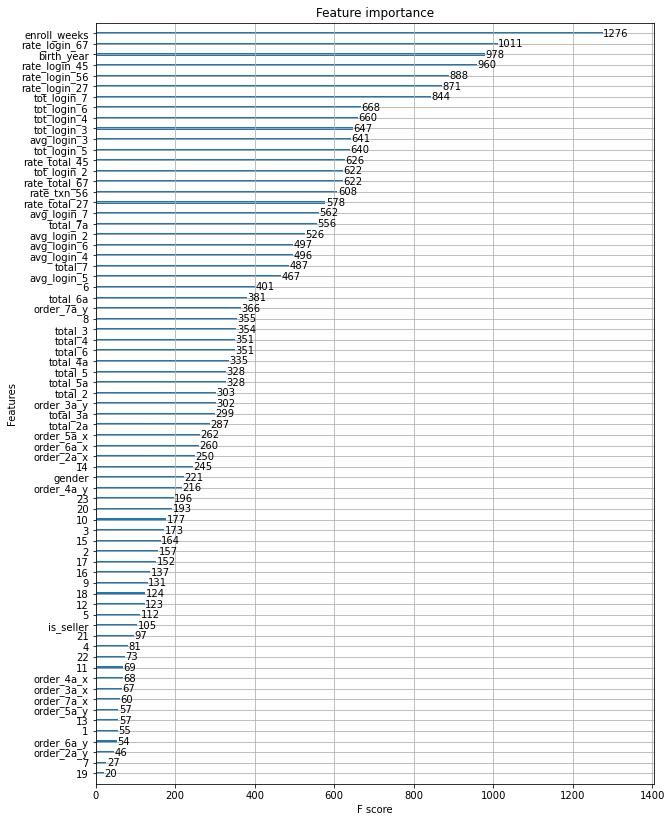

In [44]:
plot_features(model, (10,14))

## Prediction

In [45]:
x_test = df_all[df_all['data_type']==2][x_col]
test_dm = xgb.DMatrix(data = x_test)

y_pred = model.predict(test_dm)
y_pred

array([ 0.5984351 ,  0.926211  ,  0.8888489 , ...,  0.88654464,
        0.6997753 , -0.00813377], dtype=float32)

### Submission

In [46]:
df_y = pd.DataFrame()
df_y['userid'] = df_all[df_all['data_type']==2]['userid']
df_y['label'] = y_pred

In [47]:
df_y.describe()

,userid,label
count,75325.000000,75325.000000
mean,257716.578188,0.731279
std,150003.122863,0.132789
min,8.000000,-0.063172
25%,128340.000000,0.646124
50%,256156.000000,0.738587
75%,386831.000000,0.829006
max,521605.000000,1.170712


In [48]:
#Make sure final output with 0~1
df_y['label'] = (df_y['label']-min(df_y['label']))/(max(df_y['label'])-min(df_y['label']))

In [49]:
df_y.describe()

,userid,label
count,75325.000000,75325.000000
mean,257716.578188,0.643865
std,150003.122863,0.107619
min,8.000000,0.000000
25%,128340.000000,0.574848
50%,256156.000000,0.649784
75%,386831.000000,0.723064
max,521605.000000,1.000000


In [50]:
# df_y['label'] = np.where(df_y['label']>1, 1, np.where(df_y['label']<0, 0, df_y['label']))

In [51]:
df_y.to_csv('submission4.csv', index=False)